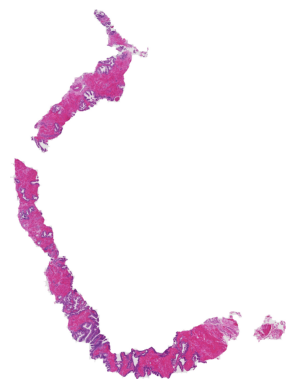

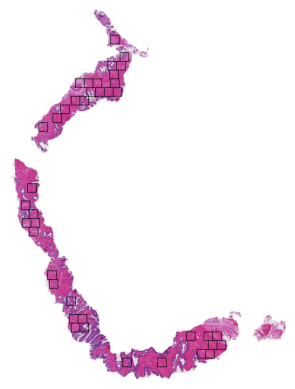

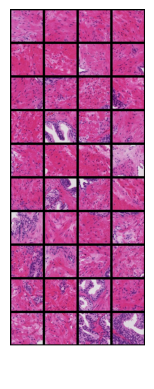

In [ ]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

%matplotlib inline

class Cell:
    '''
    Класс, описывающий ячейку изображения
    parametrs:
        x: координата х левого верхнего угла ячейки
        y: координата y левого верхнего угла ячейки
        cell_image: изображение ячейки в виде матрицы
        саncer_amount: какая часть ячейки заполнена раковыми образованиями (0 <= саncer_amount <= 1)                
    '''
    def __init__(self, x, y, cell_image, cancer_amount = 0):
        self.x = x
        self.y = y
        self.cell_image = cell_image
        self.cancer_amount = cancer_amount


def combine_images_on_background(images):
    '''
    Размещает ячейки на белом фоне

    :param images: список Cell    
    :return: изображение, составленное из ячеек, размещенных на белом фоне
    '''
    images_count = len(images)
    cols = 4
    rows = (images_count // cols) + 1

    h, w, _ = (images[0].cell_image).shape

    background = np.ones(( rows * h, cols * w, 3), dtype = np.uint8) * 255

    for i, img in enumerate(images):        
        row = i // cols
        col = i % cols

        x = col * (w)
        y = row * (h)
        
        background[y:y + h, x:x + w] = img.cell_image

    return background
    

def sliding_windows(image, win_size, win_step):
    '''
    Выделяет скользящие окна (Cell) из матрицы

    :param image: входное изображение
    :param win_size: размер окна
    :param win_step: шаг, с которым будет перемещаться окно по оси x
    :return: список Cell из подматриц исходной матрицы, которые получились путем прохода окна
    '''
    windows = list()
    h, w, _ = image.shape

    for y in range(0, h - win_size + 1, win_size):
        for x in range(0, w - win_size + 1, win_step):
            win = image[y: y + win_size, x: x + win_size]
            c = Cell(x, y, win)
            windows.append(c)

    return windows

def is_correct_cell(cell):
    '''
    Определяет стоит ли заносить данную ячейку в список тех, что нужно оставить

    :param сell: элемент списка скользящих окон
    :return: True если threshold часть ячейки заполнена раковыми образованиями, иначе - false & ячейку
    '''

    h, w, _ = cell.cell_image.shape

    threshold = 0.9 #если такая часть ячейки заполнена раковой опухолью, то запоминаем ее

    total_pixels = h * w

    non_white_sum = np.sum(cell.cell_image < 255) #Считаем все не белые пиксели, если их больше чем threshold*total_pixels, то True

    cancer_amount = non_white_sum / total_pixels

    cell.cancer_amount = cancer_amount

    return cell.cancer_amount > threshold, cell

def get_cancer_cells(image, cell_size, cell_number):
    '''
    Определяет ячейки в которых содержится больше всего информации о раковых образованиях

    :param image: фото раковых клеток
    :param cell_size: размер ячейки
    :param cell_number: количество ячеек
    :return: список из Сell, которые содержат больше всего информации о раковых образованиях
    '''
    suitable_cells = list()    

    n = 10 #нужно для определеняи шага с которым будет шагать окно в функции sliding_windows

    cell_step = cell_size // n # вместо 10 можно вписать другое разумное число
    cells_list = sliding_windows(image, cell_size, cell_step)

    i = 0
    while i != len(cells_list):  
        c = cells_list[i]
        is_correct, cell = is_correct_cell(c)      
        if(is_correct):
            suitable_cells.append(cell)                   
            i += n #Перешагиваем через n ячеек (зачем их смотреть, если они налазят на подошедшеую нам ячейку)
        else:
            i += 1

    #Сортируем по количеству раковых образований в ячейке, оставляем те, которые содержат больше всего информации
    suitable_cells.sort(key=lambda cell: cell.cancer_amount, reverse=True)
    del suitable_cells[cell_number:]

    return suitable_cells


#Исходное изображение:
image = cv2.imread('cells/train0_1.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.show()

#Выделяем на исходном изображении ячейки
cell_size = 100 #Размер ячейки
cell_number = 40 #Количество ячеек
cells = get_cancer_cells(image, cell_size, cell_number)

for cell in cells:
    cv2.rectangle(image, (cell.x, cell.y), (cell.x + cell_size, cell.y + cell_size), (0, 0, 0), 6)

plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.show()

#Выводим полученные ячейки на белом фоне
combined_cells = combine_images_on_background(cells)

plt.imshow(combined_cells, cmap = 'gray')
plt.axis('off')
plt.show()

